In [18]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import os, sys


In [2]:



df = pd.read_csv('breast-cancer.xls')

df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


# Препроцессинг датасета 

In [14]:
work_df = df.copy()

work_df.drop(columns=['id'], inplace=True)
y = work_df['diagnosis'].map({'M': 1, 'B': -1})

X = work_df.drop(columns=['diagnosis'])

In [15]:
# Final numeric matrix
X_matrix = X.values.astype(float)

# Train/validation split
X_train, X_test, y_train, y_test = train_test_split(X_matrix, y.values, test_size=0.2, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features shape (train/test):", X_train_scaled.shape, X_test_scaled.shape)
print("Class balance train:")
print(pd.Series(y_train).value_counts())
print("Class balance test:")
print(pd.Series(y_test).value_counts())

Features shape (train/test): (455, 30) (114, 30)
Class balance train:
-1    285
 1    170
Name: count, dtype: int64
Class balance test:
-1    72
 1    42
Name: count, dtype: int64


# Своя реализация SvmClassifier

In [25]:
pca = PCA(n_components=2, random_state=42)
X_train_2d = pca.fit_transform(X_train_scaled)
X_test_2d = pca.transform(X_test_scaled)

sys.path.append(os.path.join(os.getcwd(), 'source'))
from svm_classifier import SvmClassifier

toy_clf = SvmClassifier(X_train_2d.tolist(), y_train.tolist(), kernel='rbf', C=5, d=3)
toy_clf.fit()

train_pred = toy_clf.predict(X_train_2d.tolist())
test_pred = toy_clf.predict(X_test_2d.tolist())
print('Train accuracy:', accuracy_score(y_train, train_pred))
print('Test accuracy:', accuracy_score(y_test, test_pred))

Train accuracy: 0.967032967032967
Test accuracy: 0.9210526315789473


# График

C:\Users\hell0\AppData\Local\Temp\ipykernel_43384\2869430301.py:14: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_test, cmap=plt.cm.bwr, edgecolors='k', s=60, marker='x', label='test')


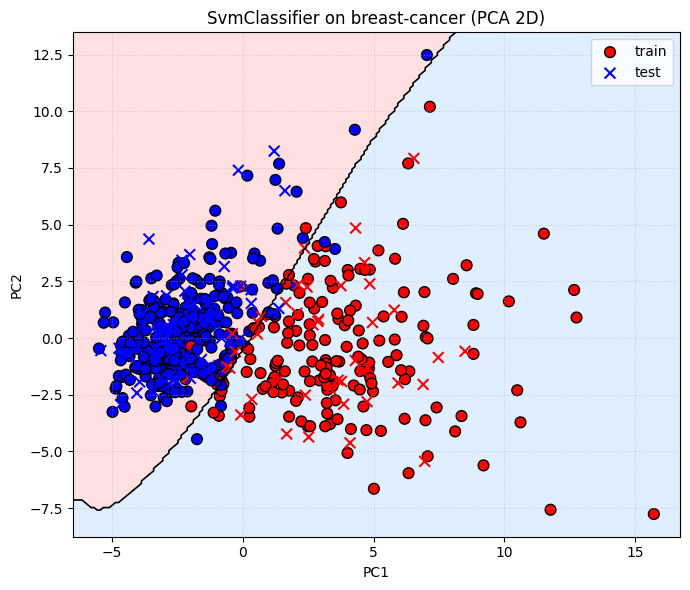

In [22]:
gx_min, gx_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
gy_min, gy_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
gxx, gyy = np.meshgrid(
    np.linspace(gx_min, gx_max, 200),
    np.linspace(gy_min, gy_max, 200),
)
grid_points = np.c_[gxx.ravel(), gyy.ravel()]
gzz = np.array(toy_clf.predict(grid_points.tolist())).reshape(gxx.shape)

plt.figure(figsize=(7, 6))
plt.contourf(gxx, gyy, gzz, levels=[-np.inf, 0, np.inf], colors=["#ffcccc", "#cce5ff"], alpha=0.6)
plt.contour(gxx, gyy, gzz, levels=[0], colors='k', linewidths=1.2)
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, cmap=plt.cm.bwr, edgecolors='k', s=60, label='train')
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_test, cmap=plt.cm.bwr, edgecolors='k', s=60, marker='x', label='test')
plt.title('SvmClassifier on breast-cancer (PCA 2D)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()

# Sklearn SVM

In [28]:


from sklearn.svm import SVC
skmodel = SVC(kernel='rbf', C=5, degree=3, random_state=42)
skmodel.fit(X_train_2d, y_train)
sk_predictions = skmodel.predict(X_test_2d)

print('Sklearn SVM Train accuracy:', accuracy_score(y_train, skmodel.predict(X_train_2d)))
print('Sklearn SVM Test accuracy:', accuracy_score(y_test, sk_predictions))


Sklearn SVM Train accuracy: 0.945054945054945
Sklearn SVM Test accuracy: 0.9385964912280702
